# MNIST 2 digits classification using 4 methods

### Authors:
- Pavlo Hilei
- Volodymyr Tsapiv

### Approaches:
- Artificial Neural Network (NN) [Hilei Pavlo]
- K-nearest neighbors (KNN) [Volodymyr Tsapiv]
- Support Vector Machine (SVM) [Hilei Pavlo]
- Logistic Regression [Volodymyr Tsapiv]


Mnist dataset consists of hand-written digits. The objective is to classify them correctly using ML approaches. In the current project we have to classify only 2 digits.

Due to the problem statement, we have to take such digits $a$, $b$, that sum of days of our birthdays form $\overline{ab}$

## 1. Data exploration and preparation

We use dataset from `torchvision.datasets` library. Let's load and check it out

In [1]:
# let's import stuff
from __future__ import annotations

from dataclasses import dataclass
from typing import Tuple, List, Dict, Callable

import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

From the whole dataset we take subset consisting of 2 passed digits, normalize photos. Also we split train to train/cross-validation

In [2]:
@dataclass
class Dataset:
    train_data: np.ndarray
    train_targets: np.ndarray
    cv_data: np.ndarray
    cv_targets: np.ndarray
    test_data: np.ndarray
    test_targets: np.ndarray


def load(digit1: int, digit2: int) -> Dataset:
    train_cv_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    train_cv_data, train_cv_targets = transform(train_cv_dataset, digit1, digit2)
    train_data, cv_data, train_targets, cv_targets = train_test_split(train_cv_data, train_cv_targets, test_size=0.2)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
    test_data, test_targets = transform(test_dataset, digit1, digit2)
    return Dataset(train_data, train_targets, cv_data, cv_targets, test_data, test_targets)


def transform(dataset: datasets.MNIST, digit1: int, digit2: int) -> Tuple[np.ndarray, np.ndarray]:
    # data = dataset.data.numpy().astype(np.float64) / 255
    # normalize data
    data = dataset.data.numpy().astype(np.float64)
    data = (data - np.mean(data)) / np.std(data)
    targets = dataset.targets.numpy()

    # filter by digits
    mask = np.bitwise_or(targets == digit1, targets == digit2)
    data = data[mask]
    targets = targets[mask]
    return data.reshape(len(data), -1), targets == digit1

Let's calculate `dig1` and `dig2`, load data

In [3]:
b1, b2 = 30, 28  # 30 and 28 are days of birthdays
n = b1 + b2
dig1 = n % 10
dig2 = n // 10
print(f"Digits are: {dig1}, {dig2}")
dataset = load(dig1, dig2)

print(f"Dataset with digits: {dig1}, {dig2}")
print(f"Size of train: {len(dataset.train_data)}, "
      f"ratio: {len(dataset.train_targets == dig1) / len(dataset.train_targets == dig2)}")
print(f"Size of cv: {len(dataset.cv_data)}, "
      f"ratio: {len(dataset.cv_targets == dig1) / len(dataset.cv_targets == dig2)}")
print(f"Size of test: {len(dataset.test_data)}, "
      f"ratio: {len(dataset.test_targets == dig1) / len(dataset.test_targets == dig2)}")

Digits are: 8, 5
Dataset with digits: 8, 5
Size of train: 9017, ratio: 1.0
Size of cv: 2255, ratio: 1.0
Size of test: 1866, ratio: 1.0


Now let's vizualize our data:

Example of images:


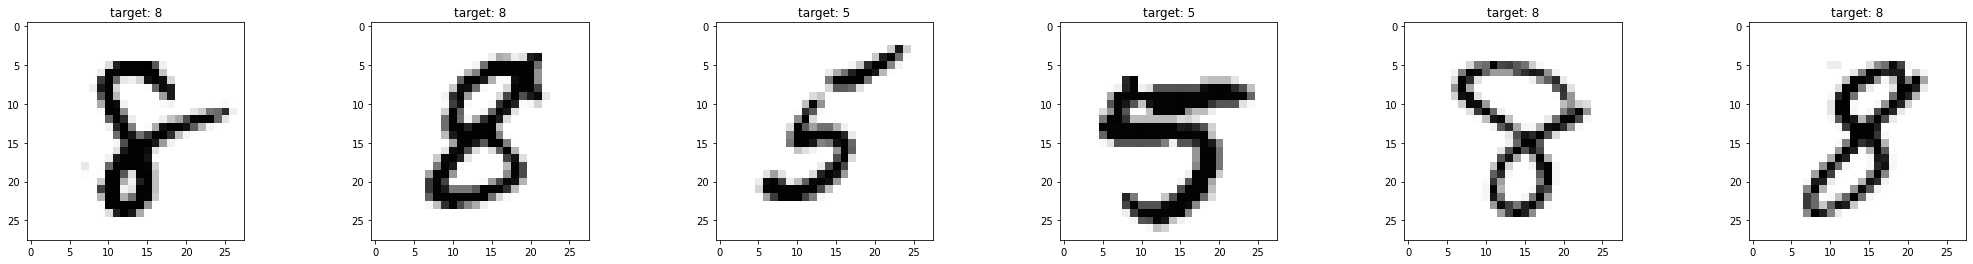

In [4]:
def show_mnist_imgs(imgs: List[np.ndarray], is_normalized=True, targets=None):
    if is_normalized:
        for idx, img in enumerate(imgs):
            img = img - np.min(img)
            img = img / np.max(img)
            img = img.reshape((28, 28))
            imgs[idx] = img
    fig, axes = plt.subplots(1, len(imgs))
    w, h = fig.get_size_inches()
    fig.set_size_inches(w * len(imgs), h)
    for idx, img in enumerate(imgs):
        axes[idx].imshow(img, cmap="Greys")
        if targets is not None:
            axes[idx].set_title(targets[idx])
    plt.show()


print("Example of images:")
bool_to_dig = {True: dig1, False: dig2}
show_mnist_imgs(list(dataset.train_data[:6]),
                targets=[f"target: {bool_to_dig[v]}" for v in dataset.train_targets[:6]])


Good. Data seems OK. now let's start with approaches.

Since we're allowed and encoureged to use libraries, and 3 of 4 methods are implemented in sklean lib, let's create some generic function that can tune paramters for best performace.

Function `select_model` takes dataset, model, and parameters. Then:
1. With the help of `grid_search` it calculates all possible combinations of parameters.
2. Trains the model.
3. Calculates accuracy on cross-validation dataset.
4. Saves model and parameters.
5. Chooses best model by accuracy score.
6. Runs best model on test dataset to score how well it performs.

In [5]:
from itertools import product


def grid_search(params):
    return [dict(zip(params, v)) for v in product(*params.values())]


def select_model(dataset: Dataset, model_prototype, parameters: Dict):
    parameters_set = grid_search(parameters)
    scores = []
    models = []

    for p in parameters_set:
        model = model_prototype(**p)
        model.fit(dataset.train_data, dataset.train_targets)

        score = model.score(dataset.cv_data, dataset.cv_targets)
        print(f"Cross-validation accuracy={score:.4f}, parameters={p}")

        models.append(model)
        scores.append(score)

    best = np.argmax(scores)
    best_model = models[best]

    score = best_model.score(dataset.test_data, dataset.test_targets)
    print(f"Test accuracy={score:.4f}, parameters={parameters_set[best]}")

    return best_model

## 1. Logistic Regression

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is **dichotomous** (binary). Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Within machine learning, logistic regression belongs to the family of **supervised** machine learning models. It is also considered a **discriminative model**, which means that it attempts to distinguish between classes (or categories). Unlike a generative algorithm, such as naïve bayes, it cannot, as the name implies, generate information, such as an image, of the class that it is trying to predict (e.g. a picture of a cat).

Logistic regression maximizes the **log likelihood** function to determine the beta coefficients of the model. This changes slightly under the context of machine learning. Within machine learning, the negative log likelihood used as the loss function, using the process of gradient descent to find the global maximum. This is just another way to arrive at the same estimations discussed below.

#### Logistic function

Let’s start by mentioning the formula of logistic function:
$$
\sigma(x) = \frac{1}{1 + e^{\theta^Tx}}
$$

There are obviously some similarities between the formula above and linear regression:
$$
y(x) = \theta^Tx
$$
The key is that we want linear regression to output the probability $p = \theta^Tx$ that has to be in 0 to 1 range, but obviously it is not the case in general. To overcome this issue we take "odds" of p:
$$
\frac{p}{1 - p} = \theta^Tx
$$
We know that odds can always be positive which means the range will always be (0,+$\infty$). Odds are nothing but the ratio of the probability of success and probability of failure. Still, left-hand side cannot obtain all the values right-hand side can; we fix by taking log of odds.
$$
\log{\frac{p}{1 - p}} = \theta^Tx
$$
Now, we can just solve for p and make sure that:
$$
p = \sigma(x) = \frac{1}{1 + e^{\theta^Tx}}
$$

#### Cost function in logistic regression

In linear regression, we use the **mean squared error** which was the difference between y_predicted and y_actual and this is derived from the maximum likelihood estimator:
$$
J(\theta) = \frac{1}{n}\sum_{i = 1}^n (\hat y_i - y_i)^2
$$
In logistic regression $\hat y_i$ is a non-linear function. If we use this in the above MSE equation then it will give a non-convex graph with many local minima.

Let’s start by defining our likelihood function. We now know that the labels are binary which means they can be either yes/no or pass/fail etc. We can also say we have two outcomes success and failure. This means we can interpret each label as Bernoulli random variable.

A random experiment whose outcomes are of two types, success S and failure F, occurring with probabilities p and q respectively is called a Bernoulli trial. If for this experiment a random variable X is defined such that it takes value 1 when S occurs and 0 if F occurs, then X follows a Bernoulli Distribution.
$$
Y \sim Bernoulli(p)
$$
where $p$ is sigmoid fuction.
$$
P[Y=y|X=x] = \sigma(\theta^Tx)^y(1 - \sigma(\theta^Tx))^{1 - y}
$$
Now for n observations,
$$
L(\theta) = \prod_{i = 1}^n \sigma(\theta^Tx_i)^{y_i}(1 - \sigma(\theta^Tx_i))^{1 - y_i}
$$
We need a value for theta which will maximize this likelihood function. To make our calculations easier we multiply the log on both sides. The function we get is also called the log-likelihood function or sum of the log conditional probability
$$
\log L(\theta) = \sum_{i = 1}^n y_i \cdot \log [\sigma(\theta^Tx_i)] + (1 - y_i) \cdot \log [(1 - \sigma(\theta^Tx_i))]
$$

#### Optimization

1. Use chain rule and break the partial derivative of log-likelihood.
$$
\frac{\partial LL(\theta)}{\partial \theta_j} = \frac{\partial LL(\theta)}{\partial p} \cdot \frac{\partial p}{\partial \theta_j}
$$
where $p = \sigma[\theta^Tx]$
$$
= \frac{\partial LL(\theta)}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \theta_j}
$$
where $z = \theta^Tx$

2. Find derivative of log-likelihood w.r.t $p$
$$
LL(\theta) = y \cdot \log p + (1 - y) \cdot \log (1 - p)
$$
$$
\frac{\partial LL(\theta)}{\partial p} = \frac{y}{p} + \frac{1 - y}{1 - p}
$$
3. Find derivative of $p$ w.r.t $z$
$$ p = \sigma(z) $$
$$
\frac{\partial p}{\partial z} = \frac{\partial \sigma(z)}{\partial z} = \sigma(z) \cdot (1 - \sigma(z))
$$
4. Find derivate of $z$ w.r.t $\theta$
$$ z = \theta^Tx $$
$$
\frac{\partial z}{\partial \theta_j} = x_j
$$
5. Put all the derivatives in equation 1

$$
\frac{\partial LL(\theta)}{\partial \theta_j} = \frac{\partial LL(\theta)}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \theta_j} = [\frac{y}{p} + \frac{1 - y}{1 - p}] \cdot \sigma(z) \cdot (1 - \sigma(z)) \cdot x_j
$$
$$
= [\frac{y}{p} + \frac{1 - y}{1 - p}] \cdot p[1 - p] \cdot x_j = [y(1 - p) - p(1 - y)] \cdot x_j = (y - p) \cdot x_j
$$
$$= (y - \sigma(\theta^Tx)) \cdot x_j $$

We can clearly see that there are no explicite solution for $\theta$ unlike in linear regression. Thus, we use **gradient ascent** in order to find the optimal $\theta$. Using equation 5 we obtain update rule:
$$
\theta_{t+1} = \theta_{t} + (y - \sigma(\theta_t^Tx)) \cdot x
$$

In [6]:
from sklearn.linear_model import LogisticRegression

parameters = {'solver': ['saga', 'lbfgs', 'liblinear', 'newton-cg', 'sag'], 'max_iter': [200], 'C': [1, 0.1, 0.03]}
select_model(dataset, LogisticRegression, parameters)

Cross-validation accuracy=0.9557, parameters={'solver': 'saga', 'max_iter': 200, 'C': 1}
Cross-validation accuracy=0.9570, parameters={'solver': 'saga', 'max_iter': 200, 'C': 0.1}
Cross-validation accuracy=0.9592, parameters={'solver': 'saga', 'max_iter': 200, 'C': 0.03}
Cross-validation accuracy=0.9548, parameters={'solver': 'lbfgs', 'max_iter': 200, 'C': 1}
Cross-validation accuracy=0.9557, parameters={'solver': 'lbfgs', 'max_iter': 200, 'C': 0.1}
Cross-validation accuracy=0.9588, parameters={'solver': 'lbfgs', 'max_iter': 200, 'C': 0.03}
Cross-validation accuracy=0.9557, parameters={'solver': 'liblinear', 'max_iter': 200, 'C': 1}
Cross-validation accuracy=0.9579, parameters={'solver': 'liblinear', 'max_iter': 200, 'C': 0.1}
Cross-validation accuracy=0.9592, parameters={'solver': 'liblinear', 'max_iter': 200, 'C': 0.03}
Cross-validation accuracy=0.9565, parameters={'solver': 'newton-cg', 'max_iter': 200, 'C': 1}
Cross-validation accuracy=0.9561, parameters={'solver': 'newton-cg', 'ma

LogisticRegression(C=0.03, max_iter=200, solver='saga')

#### Logistic regression pros

**Pros**:
- Easy to implement
- The predicted parameters (trained weights) give inference about the importance of each feature. (Highly interpretable)
- This algorithm allows models to be updated easily to reflect new data, unlike decision trees or support vector machines. The update can be done using stochastic gradient descent.
- Logistic regression outputs well-calibrated probabilities along with classification results. This is an advantage over models that only give the final classification as results.
- In a low dimensional dataset having a sufficient number of training examples, logistic regression is less prone to over-fitting.

**Cons**:
- Non-linear problems can't be solved with logistic regression since it has a linear decision surface. Linearly separable data is rarely found in real world scenarios.
- The training features are known as independent variables. Logistic Regression requires moderate or no multicollinearity between independent variables. Repetition of information could lead to wrong training of parameters (weights) during minimizing the cost function.
- On high dimensional datasets with an insufficient number of data samples, the model is prone to over-fit on the training set.

Test logistic regression accuracy on test data - 95.8%

Note that best cross-validation accuracy we get with more strict regularization 0.1 (default is 1.0). It might be due to the fact that our data is high-dimensional (784d). I believe that results can be improved by apply PCA before classification.

## 2. K-nearest neighbors

K-nearest Neighbor is a **supervised classification** algorithm that is based on predicting data by finding the similarities to the underlying data. KNN is most widely used for classification problems, but can also be used to solve regression problems. The original assumption is the data exist in forms of clusters or exist in close proximity. KNN is a non-parametric algorithm, which means it does not attempt to make an assumption on the data, for example it does not care if the data is normally distributed or not.

#### Classification rule

Informally:

For a test input x, assign the most common label amongst its k most similar training inputs

Formally:

Let $x$ to be test point. Define the set of the k nearest neighbors of $x$ as $S_x$. $S_x$ is defined as $S_x \subseteq D$ s.t. $|S_x|=k$ and
$$
\forall (x', y') \in D \setminus S_x \quad dist(x, x') \ge \max_{(x'', y'') \in S_x} dist(x, x''),
$$
(i.e. every point in D but not in $S_x$ is at least as far away from $x$ as the furthest point in $S_x$). We can then define the classifier h() as a function returning the most common label in $S_x$:
$$
h(x) = mode({y'': (x'', y'') \in S_x}),
$$
where $mode(\cdot)$ means to select the label of the highest occurrence.

#### Distance function

The k-nearest neighbor classifier fundamentally relies on a distance metric. The better that metric reflects label similarity, the better the classified will be. The most common choice is the Minkowski distance
$$
dist(x, z) = (\sum_{r=1}^d |x_r - z_r|^p)^{\frac{1}{p}}
$$
- p = 1: Manhattan Distance ($l_1$-norm)
- p = 2: Euclidean Distance ($l_2$-norm)
- p $\to \infty$: Maximum Norm

#### 1-NN Convergence proof


Cover and Hart 1967: As $n \to \infty$, the 1-NN error is no more than twice the error of the Bayes Optimal classifier. (Similar guarantees hold for k>1.)

Let $x_{NN}$ be the nearest neighbor of our test point $x_t$. As $n \to \infty$, dist($x_{NN},x_t$) $\to 0$, i.e. $x_{NN} \to x_t$. (This means the nearest neighbor is identical to $x_t$.) You return the label of $x_{NN}$. What is the probability that this is not the label of x? (This is the probability of drawing two different label of x)
$$
\varepsilon_{NN} = P(y^*|x_t)(1 - P(y^*|x_{NN})) + P(y^*|x_{NN})(1 - P(y^*|x_t)) \le (1 - P(y^*|x_{NN})) + (1 - P(y^*|x_t)) = 2(1 - P(y^*|x_t)) = 2\varepsilon_{BayesOpt}
$$

#### Curse of dimensionality


Imagine $X=[0,1]^d$, and k=10 and all training data is sampled uniformly with X, i.e. $\forall i,x_i \in [0,1]^d$. Let $l$ be the edge length of the smallest hyper-cube that contains all k-nearest neighbor of a test point. Then $l^d \approx \frac{k}{n}$ and $l \approx (\frac{k}{n})^{1/d}$
Let's take $n = 1000$ and how $l$ changes as d grows:
$$
d \quad l \\
2 \quad 0.1 \\
10 \quad 0.63 \\
100 \quad 0.955 \\
1000 \quad 0.9954
$$
Almost the entire space is needed to find the 10-NN.




In [7]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': list(range(11, 30, 2))}
select_model(dataset, KNeighborsClassifier, parameters)

Cross-validation accuracy=0.9876, parameters={'n_neighbors': 11}
Cross-validation accuracy=0.9863, parameters={'n_neighbors': 13}
Cross-validation accuracy=0.9871, parameters={'n_neighbors': 15}
Cross-validation accuracy=0.9871, parameters={'n_neighbors': 17}
Cross-validation accuracy=0.9863, parameters={'n_neighbors': 19}
Cross-validation accuracy=0.9854, parameters={'n_neighbors': 21}
Cross-validation accuracy=0.9849, parameters={'n_neighbors': 23}
Cross-validation accuracy=0.9836, parameters={'n_neighbors': 25}
Cross-validation accuracy=0.9840, parameters={'n_neighbors': 27}
Cross-validation accuracy=0.9831, parameters={'n_neighbors': 29}
Test accuracy=0.9904, parameters={'n_neighbors': 11}


KNeighborsClassifier(n_neighbors=11)

#### k-NN pros and cons

**Pros**:
- intuitive and simple: k-NN algorithm is very simple to understand and equally easy to implement.
- no assumptions: K-NN is a non-parametric algorithm which means there are assumptions to be met to implement it.
- no training step: Given it’s an instance-based learning; k-NN is a memory-based approach. The classifier immediately adapts as we collect new training data.
- easy to implement for multi-class problem: Most of the classifier algorithms are easy to implement for binary problems and needs effort to implement for multi class.
- can be used both for classification and regression
- only one hyper-parameter
- variety of distance criteria to be choose from: Euclidean dist, Hamming dist, Manhattan dist and Minkowski dist as most general

**Cons**:
- slow algorithm: k-NN might be very easy to implement but as dataset grows efficiency or speed of algorithm declines very fast.
- curse of dimensionality: k-NN works well with small number of input variables but as the numbers of variables grow k-NN algorithm struggles to predict the output of new data point.
- k-NN needs homogeneous features: If you decide to build k-NN using a common distance, like Euclidean or Manhattan distances, it is completely necessary that features have the same scale, since absolute differences in features weight the same, i.e., a given distance in feature 1 must means the same for feature 2.
- whhat is optimal number of neighbors
- imbalanced data causes problems
- outlier sensitivity
- missing value treatment: k-NN inherently has no capability of dealing with missing value problem.

Test k-NN accuracy on test data - 99.0%

## 3. Artificial Neural Network


Arificial Neural network is quite a big set of algorithms. The main idea is inspired by how our brains works, though it has a lot less in common that we may think.

An ANN is based on a collection of connected units or nodes called artificial neurons or perceptron, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit signal to other neurons.

There is a Universal approximation theorem[7] that shows, that actually any function can be estimated with a big enough ANN

#### General idea

'Signal' in a computer is just a float number. The bigger number corresponding to particular neuron, the bigger its activation. There can be many layers of neurons.

In a 'classic' Linear Fully conncted network, neurons at each layer are interconnected with all neurons from previous and next layers. Exceptions are input layers (input we get from data), and output layer.

Those connections are called edges, and they have some weights (learnable parameters), that explain how different neurons from previos layer impact activation of current neuron from current layer. This simple structure can make network learn difficult pattern


Usually one step inside such network can be described in terms of matrix multiplication. Let's say that for some perceptron $i$ on layer $k$ we have vector of weights $w_i$ for each perceptron from previous layer. Then activatin of such neuron can written as a linear combination of activations of all the perceptrons from previous step: $a_i^k=w_{i1} \cdot a_1^{k-1} + w_{i2} \cdot a_2^{k-1} + \cdots w_{in} + \cdot a_n^{k-1} + b_i=w_i \cdot a^{k-1} + b_i$

Then we can rewrite one layer of activation as a matrix multiplication:

$$a^k = W^k \cdot a^{k-1} + b$$
$$W^k=\begin{bmatrix}
-- w_1^k -- \\
-- w_2^k -- \\
-- \cdots -- \\
-- w_n^k -- \\
\end{bmatrix}
$$


-----------


<img src="./media/nn.jpeg" alt="drawing" width="500"/>

#### Activation functions

To make ANN learn a non-linear patterns, we have to add so-called 'activation function'. That is some non-linear function `A` that is applied to each neuron at some layer.

Ths most popular are:
- Sigmoid: $S(a) = \frac{1}{1+e^{-x}}$
- tanh: $T(a) = \frac{e^{2x} - 1}{e^{2x} + 1}$
- Relu: $R(a) = max(0, a)$
- Parametruc Relu: $Pr(a) = a$ if $a>0$ otherwise $ax$

#### Learning ANN

The most popular and most practical way to learn weights and train model - back propagation.

That is basically feed data to ANN, compute some loss function (usually defined by the problem we're solving), compute gradients using chain rule, and using some clever modification of gradient descent update all weights in the model. Repeat this process unless value of loss function converges, or we get good enough metrics.

Without too much of details, Let's say we have value of loss function $C$. Now since loss function is known, and usually differentiated function is takes as a loss function, we can compute $\frac{dC}{dA^k}$, where $A^k$ is a output of the model.

Then since we know derivative of activation function, we can compute $\frac{dC}{da^k} = \frac{dC}{dA^k} \cdot \frac{dA^k}{da^k}$, where $a^k$ - perceptrons activations on the last layer. Now since we know that activations are just a linear function of the output of previous step, we can continue this process, until we get to the input layer.

#### Implementation

In 99% of situations, creating neural network from scratch is not needed, since modern high-level frameworks propose a ton of functionality. Let's use `pytorch` to create a relatively simple fully connected neural network:

In [8]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader


class LinearMnistNN(nn.Module):
    def __init__(self,
                 layers_sizes: List | None = None,
                 activation=F.relu,
                 n_classes=2,
                 input_size=784):
        super().__init__()
        if layers_sizes is None:
            layers_sizes = [16, 16]
        self.activation = activation
        self.n_classes = n_classes

        prev_size = input_size
        for i, cur_size in enumerate(layers_sizes):
            self.__setattr__(f"linear_{i}", nn.Linear(prev_size, cur_size))
            prev_size = cur_size
        self.__setattr__(f"linear_{i + 1}", nn.Linear(prev_size, n_classes))
        self.n_layers = len(layers_sizes) + 1

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i in range(self.n_layers):
            x = self.activation(self.__getattr__(f"linear_{i}")(x))
        x = F.softmax(x, 1)
        return x


class MNIST_Dataset(TorchDataset):
    def __init__(self,
                 dataset: Dataset,
                 train=False,
                 cv=False,
                 test=False,
                 length: int | None = None,
                 ) -> None:
        super().__init__()
        if sum((train, cv, test)) != 1:
            raise ValueError("Choose only one - train/cv/test")
        if train:
            self.data = dataset.train_data[:length]
            self.labels = dataset.train_targets[:length]
        elif cv:
            self.data = dataset.cv_data[:length]
            self.labels = dataset.cv_targets[:length]
        elif test:
            self.data = dataset.test_data[:length]
            self.labels = dataset.test_targets[:length]
        self.data = torch.from_numpy(self.data.astype(np.float32))
        self.labels = torch.from_numpy(self.labels.astype(np.int))
        self.length = length if length is not None else len(self.labels)

    def __getitem__(self, index: int):
        return torch.flatten(self.data[index]), self.labels[index]

    def __len__(self):
        return self.length

Neural network above can be configured - we can choose number of hidden layers, and their sizes. Also, we can choose an activation function.

For a convenience, I also created dataset wrapper, that can work well with a torch.

Model training also requires quite a lot of code:

In [9]:
from sklearn.metrics import f1_score, accuracy_score
import copy


def train_one_epoch(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
                    training_loader: DataLoader, loss_fn: Callable,
                    print_each: int, verbose=False,
                    ) -> List[float]:
    running_loss = 0.
    loss_history = []
    for i, data in enumerate(training_loader):
        inputs, labels = data  # get data from batch
        optimizer.zero_grad()  # Zero your gradients for every batch
        outputs = model(inputs)  # Make predictions for this batch
        loss = loss_fn(outputs, labels)  # Compute the loss and its gradients
        loss.backward()
        optimizer.step()  # Adjust learning weights

        # Gather data and report
        running_loss += loss.item()
        if i % print_each == print_each - 1:
            last_loss = running_loss / print_each  # loss per batch
            verbose and print(f"  batch {i + 1} loss: {last_loss}")
            loss_history.append(float(last_loss))
            running_loss = 0.
    return loss_history


def train_model(
        model: torch.nn.Module, optimizer: torch.optim.Optimizer, config: Dict
) -> Tuple[Dict[str, List], torch.nn.Module | None]:
    deep_cnf = config["deep_model"]
    loss_fn = torch.nn.CrossEntropyLoss()  # loss function - cross entropy

    train_ds = MNIST_Dataset(dataset, train=True)
    cv_ds = MNIST_Dataset(dataset, cv=True)

    # prepare data loader
    training_loader = DataLoader(
        train_ds, batch_size=deep_cnf["batch_size"], shuffle=True, num_workers=deep_cnf["loader_num_workers"]
    )
    validation_loader = DataLoader(
        cv_ds, batch_size=deep_cnf["batch_size"], shuffle=False, num_workers=deep_cnf["loader_num_workers"]
    )

    print_each = deep_cnf["print_each"]
    n_epoch = deep_cnf["n_epoch"]

    history = {
        "avg_cv_loss": [],
        "train_loss": [],
        "avg_accuracy": [],
        "avg_f1": [],
    }

    best_model = None
    best_cv_acc = -1

    for epoch in range(n_epoch):
        model.train()  # put model in a train mode
        loss_h = train_one_epoch(model, optimizer, training_loader, loss_fn, print_each, verbose=False)
        model.eval()  # put model in evaluation mode
        cv_loss = 0.0
        cv_accuracy = 0.0
        cv_f1 = 0.0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            cv_loss += vloss.item()

            preds = voutputs.max(dim=1)[1].numpy()
            cv_accuracy += accuracy_score(vlabels, preds)
            cv_f1 += f1_score(vlabels, preds)

        history["avg_accuracy"].append(float(cv_accuracy / (i + 1)))
        history["avg_f1"].append(float(cv_loss / (i + 1)))
        history["avg_cv_loss"].append(float(cv_f1 / (i + 1)))
        history["train_loss"] += loss_h

        avg_train_loss = np.mean(loss_h)
        print(f"EPOCH: {epoch} done. loss: {avg_train_loss}, accuracy: {history['avg_accuracy'][-1]}")

        # update best model
        if history['avg_accuracy'][-1] > best_cv_acc:
            best_model = copy.deepcopy(model)
            best_cv_acc = history['avg_accuracy'][-1]

    return history, best_model


Also, we will need some functions to evaluate model on the test dataset, vizualize training history:

In [10]:
from torch.nn import Module


def vizualize_history(history: Dict):
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig_width, fig_height = fig.get_size_inches()
    fig.set_size_inches(fig_width, fig_height * 3)
    idx = 0
    for key in history:
        if key == "train_loss":
            continue
        axes[idx].set_title(key)
        axes[idx].set_xlabel("epoch")
        axes[idx].plot(history[key])
        idx += 1
    plt.show()
    plt.title("train loss")
    plt.plot(history["train_loss"])
    plt.xlabel("epoch")
    plt.show()


def eval_model(model: Module) -> Dict:
    model.eval()

    inputs = torch.from_numpy(dataset.test_data.astype(np.float32))
    labels = dataset.test_targets

    outputs = model(inputs)
    preds = outputs.max(dim=1)[1].numpy()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)

    print(f"Test accuracy: {acc}, f1-score: {f1}")
    return {
        "accuracy": acc,
        "f1-score": f1,
    }

EPOCH: 0 done. loss: 0.36603465168564403, accuracy: 0.9766725352112676
EPOCH: 1 done. loss: 0.33797849030406385, accuracy: 0.9744718309859155
EPOCH: 2 done. loss: 0.3367593021304519, accuracy: 0.9651701877934273
EPOCH: 3 done. loss: 0.33636394728113106, accuracy: 0.963849765258216
EPOCH: 4 done. loss: 0.33723340012409075, accuracy: 0.9709507042253521
EPOCH: 5 done. loss: 0.3369850035066958, accuracy: 0.971830985915493
EPOCH: 6 done. loss: 0.3336468584007687, accuracy: 0.977112676056338
EPOCH: 7 done. loss: 0.33518282274405165, accuracy: 0.9762323943661971
EPOCH: 8 done. loss: 0.3345173717648895, accuracy: 0.9766725352112676
EPOCH: 9 done. loss: 0.33342278323791646, accuracy: 0.9740316901408451
EPOCH: 10 done. loss: 0.33302864586865455, accuracy: 0.9727112676056338
EPOCH: 11 done. loss: 0.33406657300613546, accuracy: 0.9757922535211268
EPOCH: 12 done. loss: 0.33432494479197045, accuracy: 0.9810739436619719
EPOCH: 13 done. loss: 0.3359412990234516, accuracy: 0.9788732394366197
EPOCH: 14 

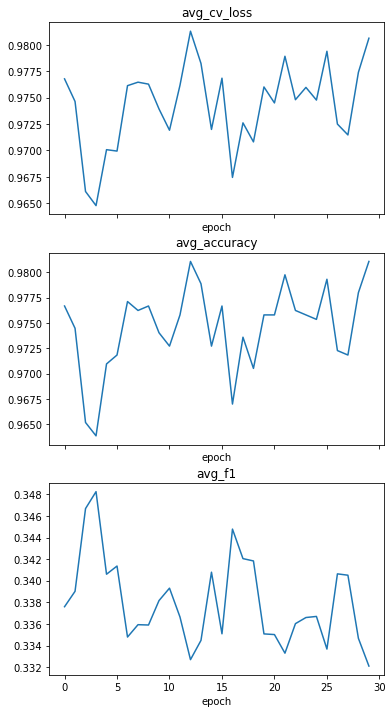

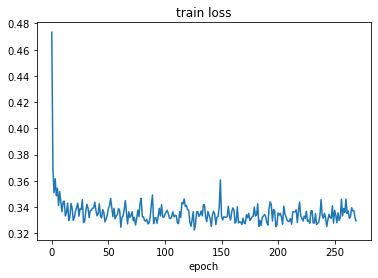

Test accuracy: 0.9828510182207931, f1-score: 0.9835728952772074


{'accuracy': 0.9828510182207931, 'f1-score': 0.9835728952772074}

In [11]:
from torch.optim import Adam

config = {
    "deep_model": {
        "linear": {
            "layers_sizes": [16, 16],
            "activation": "relu",
        },
        "batch_size": 32,
        "loader_num_workers": 4,
        "print_each": 30,
        "n_epoch": 30,
    }

}

model = LinearMnistNN()
optimizer = Adam(list(model.parameters()), lr=0.005, weight_decay=0.001)
history, best_model = train_model(model, optimizer, config)
vizualize_history(history)

eval_model(best_model)

Now let's try to fine tune the model:

In [15]:
from pprint import pprint


def grid_search_nn(
        layers: List[List[int]],
        optimizers: List[Tuple[type, Dict[str, float]]],
        activations: List[Callable],
        config: Dict,
):
    very_best_model = None
    very_best_val_accuracy = -1
    very_best_config = {}
    results = []

    for layer_sizes in layers:
        print(f"Current layers: {layer_sizes}")
        for opt_cnf in optimizers:
            opt_cnf_full = copy.deepcopy(opt_cnf[1])
            opt_cnf_full.update({"name": opt_cnf[0].__name__})
            print(f"  Current optimizer: {opt_cnf_full}")
            for activation in activations:
                print(f"    Current activation: {activation.__name__}")
                model = LinearMnistNN(layer_sizes, activation)
                optimizer = opt_cnf[0](list(model.parameters()), **opt_cnf[1])

                history, best_model = train_model(model, optimizer, config)

                cur_best_cv_acc = min(history["avg_cv_loss"])
                # cur_best_cv_f1 = min(history["avg_f1"])

                cur_configuration = {
                    "layers": layer_sizes,
                    "activation": activation.__name__,
                    "optimizer_cnf": opt_cnf_full,
                    "cv_accuracy": cur_best_cv_acc,
                }

                if cur_best_cv_acc > very_best_val_accuracy:
                    very_best_model = best_model
                    very_best_config = cur_configuration
                    very_best_val_accuracy = cur_best_cv_acc

                results.append(cur_configuration)

    print(f"best model has accuracy {very_best_val_accuracy}, and config:")
    pprint(very_best_config)
    return results, very_best_model

In [ ]:
from torch.optim import SGD
from torch.nn.functional import relu
from torch import sigmoid


layers = [
    [16, 16],
    [64, 32, 16]
]

optimizers = [
    (Adam, {"lr": 0.005, "weight_decay": 0.005}),
    (Adam, {"lr": 0.0005, "weight_decay": 0.001}),
    (SGD, {"lr": 0.005, "weight_decay": 0.005}),
    (SGD, {"lr": 0.0005, "weight_decay": 0.001}),
]

activations = [relu, sigmoid]


results, very_best_model = grid_search_nn(layers, optimizers, activations, config)
eval_model(very_best_model)


*Note that I removed ouput of previous cell, since it was huge*

Test ANN accuracy on test data - 99.0%.

It's quite interesting, looks like model from time to time gets into some local minimum, and can't get out of it.

Turns out used loss - cross etropy loss function ($L = \sum_{i=1}^n y_i log(\hat{y_i})$) is not convex[2] for weights of hidden layers

**Pros**
- With more sophisticated architectures, can outperform classical approaches a lot
- Can solve some problems previously considered too dificult for computers (computer speech, image generation, translation, etc)
- Some deep models, like Transformers for example can generelize well for many other problems.

**Cons**:
- Quite easy to overfit
- For greate performance requires a huge amount of data
- Huge amount of data requires a lot of computational power and money to train a sophisticated model
- Sometimes doesn't generelizes well


## 4. Support Vector Machine (SVM)

SVM is a classical model. The main idea is to find hyper-plane in a space such that best divides points into spaces.

The "best" usually means - minimize margin (gap) formed by a hyperplane and support vectors.

#### SVM as an optimization problem

There are quite a few iterative approaches and estimates that can produce solutions, but the most common way to find target hyperplance is to solve SVM as a classical optimization problem.

Let $f(\mathbf{x}) = \mathbf{x}\cdot \mathbf{w} + b$ be a linear classifier predicting the responce variable $y$ via
$$
  y = \operatorname{sign}(f(\mathbf{x}))
$$

The task is to maximize the margin, i.e., the value $M$ s.t., for all $j$,
$$
   y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge M \|\mathbf{w}\|
$$
By rescaling $\mathbf{w}$ (and $b$) so that $M\cdot\|\mathbf{w}\| = 1$, we get an equivalent problem
\begin{align}
\operatorname{argmin}_{\mathbf{w}, b}  &\frac12 \|\mathbf{w}\|^2 \\
\text{subject to } \qquad &y_j (\mathbf{x}_j \cdot \mathbf{w} + b) \ge 1
\end{align}

The Lagrange function is
$$
  \mathscr{L}(\mathbf{w}, b, \lambda) = \frac12\|\mathbf{w}\|^2 + \sum_j \lambda_j  [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)]
$$
Partial derivatives in $\mathbf{w}$ and $b$ give the equalities
$$
    \mathbf{w} = \sum_j \lambda_j y_j \mathbf{x}_j \qquad \text{and} \qquad 0 = \sum_j \lambda_j y_j;
$$
we now use these in $\mathscr{L}$ to get the Wolfe dual problem of maximizing the quadratic problem
\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \mathbf{x}_j\cdot\mathbf{x}_k \tag{1}
\end{equation}
subject to the restrictions $\lambda_j \ge 0$.

In addition to the above relations, the following constraints should be satisfied for every $j$:
$$
   \lambda_j [1 - y_j(\mathbf{x}_j\cdot \mathbf{w} + b)] = 0
$$
Indices $j$ for which $y_j(\mathbf{x}_j\cdot \mathbf{w} + b) = 1$ correspond to *support vectors* (i.e., points on the margin boundary).


#### Soft margin SVM
in a real life, usually data is not linearly separable. For such problem there is a so-called "soft margin" SVM. The idea is make some hyperparameter, that allows us to make some missclassification.

To this end, we introduce slack variables $\xi_j\ge0$ and impose relaxed  constraints
$$
  y_j[\mathbf{x}_j\cdot \mathbf{w} + b] \ge 1 - \xi_j. \tag{2}
$$
The slack variables
$$
  \xi_j = \max\{0, 1- y_j[\mathbf{x}_j \cdot \mathbf{w} + b]\}
$$
measure incorrectness of classification: $\xi_j = 0$ for correctly classified points outside the slab and $\xi_j >0$ for points that fall inside the slab or are in the wrong halfspace. The new objective function is
$$
  f(\mathbf{w},b,\xi_j) = \frac12\|\mathbf{w}\|^2 + C \sum_j \xi_j
$$
under the constraints (2); here $C$ is the cost constant penalizing misclassification.

#### Gradient descent
After we calculated cost function, we can calculate gradients, and solve the problem with gradient descent.

$$\nabla_{\mathbf{w}}g = \mathbf{w} - C \sum_{\xi_j>0} y_j x_j$$

$$\frac{\partial g}{\partial b} = -C \sum_{\xi_j>0}  y_j$$


#### Kernel trick

The idea of the trick - map data into some higher dimensional space. Not separable data may become linearly separable.

As we can see in the Wolfe problem, we need to only define a dot product of vectors.

\begin{equation}
   \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, \mathbf{x}_j\cdot\mathbf{x}_k \tag{1}
\end{equation}

That's why we can use a kernel function, that is just a dot product of two mapped vectors $K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)$

So new Wolfe problem:
$$
  \mathscr{L}_D = \sum_j \lambda_j - \frac12 \sum_{j,k} \lambda_j\lambda_k y_jy_k \, K(\mathbf{x}_j, \mathbf{x}_k)
$$


In [14]:
from sklearn.svm import SVC

parameters = {
    'kernel': ['sigmoid', 'rbf', 'poly'],
    'degree': [3, 4, 5],
}
select_model(dataset, SVC, parameters)

Cross-validation accuracy=0.8696, parameters={'kernel': 'sigmoid', 'degree': 3}
Cross-validation accuracy=0.8696, parameters={'kernel': 'sigmoid', 'degree': 4}
Cross-validation accuracy=0.8696, parameters={'kernel': 'sigmoid', 'degree': 5}
Cross-validation accuracy=0.9929, parameters={'kernel': 'rbf', 'degree': 3}
Cross-validation accuracy=0.9929, parameters={'kernel': 'rbf', 'degree': 4}
Cross-validation accuracy=0.9929, parameters={'kernel': 'rbf', 'degree': 5}
Cross-validation accuracy=0.9911, parameters={'kernel': 'poly', 'degree': 3}
Cross-validation accuracy=0.9845, parameters={'kernel': 'poly', 'degree': 4}
Cross-validation accuracy=0.9676, parameters={'kernel': 'poly', 'degree': 5}
Test accuracy=0.9941, parameters={'kernel': 'rbf', 'degree': 3}


SVC()

**Pros**:
- Works well, when data is easyly separable
- Effective in a high dimensional space
- Works well, when the number of dimensions os bigger than number of samples
- Memory efficient

**Cons**:
- Doesn't work well, when data is not easyly separable and noisy
- Training time is O(n^2), so it's not suitable for huge datasets
- Model is not probabilistic, we label points with just 1/-1.


Test SVM accuracy on test data - 99.4%.

## Summary

**Rank:**
1. SVM - 99.4%
2. k-NN - 99.0%
3. ANN - 99.0%
4. Logistic regression - 95.8%

In this report, we've tried to consider classification approaches that are as different as possible. I think that almost accomplished it except for ANN and Logistic regression, where the last one can be viewed as a simplified version of ANN. Overall, I think we've managed to get pretty good accuracy for most of the methods and discussed reasons for logistic regression's poor performance. To be honest, the final ranking of the models was a little surprising for us - that's, I believe, a good lesson showing why in machine learning, you must never stick to some favorite model without testing others.

### References
- [1] - Artificial neural network - [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network)
- [2] - Is Cross entropy cost function for neural network convex? - [StackExchange](https://stats.stackexchange.com/questions/144378/is-cross-entropy-cost-function-for-neural-network-convex)
- [3] - BackPropagation - [Wikipedia](https://en.wikipedia.org/wiki/Backpropagation)
- [4] - What is Support Vector Machine (SVM)? - [Medium](https://medium.com/@cdabakoglu/what-is-support-vector-machine-svm-fd0e9e39514f)
- [5] - Lab work #2 SVM - MMML course.
- [6] - Understanding Support Vector Machine(SVM) algorithm from examples - [Analytics Vidhuya](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)
- [7] - Universal approximation theorem - [Wikipedia](https://en.wikipedia.org/wiki/Universal_approximation_theorem)
- [8] - Conceptual Understanding of Logistic Regression for Data Science Beginners - [Analytics Vidhuya](https://www.analyticsvidhya.com/blog/2021/08/conceptual-understanding-of-logistic-regression-for-data-science-beginners/#h2_5)
- [9] - Advantages and Disadvantages of Logistic Regression - [OpenGenus](https://iq.opengenus.org/advantages-and-disadvantages-of-logistic-regression/)
- [10] - k-nearest neighbors - [CS.Cornell](https://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote02_kNN.html)
- [11] - Pros and Cons of K-Nearest Neighbors - [Genesis](https://www.fromthegenesis.com/pros-and-cons-of-k-nearest-neighbors/)